### Latest

There is just one more iteration of models that I would like to try. We will only do major and topic_1 models (no minor topics model, and only SVM with linear kernel) with the following changes:

1. Use bills93-114.csv as it has more data. It will need to be cleaned and tokenized though.

*** use old bills dataset between 103 - 112 ***

2. Support for some topics is very low. For instance, just 2--5 rows for some minor topics. I have revised topic_1 in topic_code.csv to remove most of these topics. So that should improve our classification success a lot.

3. For test data, can we also output:
true class, prob_class_1, prob_class_2 ...., .....prob_class_k

Final steps for maj_topics (similar for topic_1):

1. Read bills93-114.csv
2. Clean and tokenize

*** use old bills dataset between 103 - 112 ***

3. Split long bills into 2.5k chunks. 5k may be still too long. (And I mean 2500 characters, not 2500 words, which is super long. 2500 characters ~ 500 words. I apologize for any confusion.) 
4. Read in Roberts rules and takes out those tokens
5. Remove tokens that appear in 10 or fewer bills. Also remove tokens that appear in more than 5,000 bills.
6. Fit SVM with linear kernel
7. Merge with topic_code
8. For test data, produce: true_class, prob_class_1,..... prob_class_k
9. Output top 20 most informative for each class
10. Predict all congress (after chunking into 2.5k characters) and all news 

Other Notes:

1. It doesn't appear we are tuning c or gamma in SVM. We can also decide on kernels using cross-validation. See this: 
http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html 

It is ok for now. But something to look into in the future. We can also look into other models.


In [1]:
import pandas as pd
import numpy as np
import time

## Read Bills dataset (cleaned version)

In [2]:
df = pd.read_csv('../data/bills-out-clean.csv.gz', nrows=10)
df.columns

Index([u'uid', u'Major', u'Minor', u'clean_text'], dtype='object')

In [3]:
df = pd.read_csv('../data/bills-out-clean.csv.gz', usecols=['Major', 'Minor', 'clean_text'])
df

,Major,Minor,clean_text
0,20,2012,congression bill 103th congress us govern prin...
1,3,300,congression bill 103th congress us govern prin...
2,15,1520,congression bill 103th congress us govern prin...
3,20,2000,congression bill 103th congress us govern prin...
4,15,1522,congression bill 103th congress us govern prin...
5,1,107,congression bill 103th congress us govern prin...
6,14,1401,congression bill 103th congress us govern prin...
7,1,107,congression bill 103th congress us govern prin...
8,14,1406,congression bill 103th congress us govern prin...
9,3,331,congression bill 103th congress us govern prin...


## Split long bill to smaller chunk (2500 chars)

In [4]:
import re
import textwrap

def insert_chars_split_marker(text, cc=2500):
    # FIXME: text still has number
    text = re.sub('\d+', '', text)
    out = '|'.join(textwrap.wrap(text, cc))
    return out

def insert_words_split_marker(text, wc=500):
    text = re.sub('\d+', '', text)
    words = text.split()
    out = ''
    for i, w in enumerate(words):
        if i != 0 and i % wc == 0:
            out += '|' + w
        else:
            out += ' ' + w
    return out

In [5]:
if True:
    df['clean_text'] = df['clean_text'].apply(lambda c: insert_chars_split_marker(c, 2500))

In [6]:
if True:
    s = df['clean_text'].str.split('|', expand=True).stack()
    i = s.index.get_level_values(0)
    new_df = df.loc[i].copy()
    new_df['chunk'] = s.index.get_level_values(1)
    new_df['clean_text'] = s.values
    df = new_df

## Vectorize

In [7]:
import nltk
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer
import re
import string

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#def tokenize(text):
#    tokens = nltk.word_tokenize(text)
#    stems = stem_tokens(tokens, stemmer)
#    return stems

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas_confusion import ConfusionMatrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split



In [9]:
with open('../roberts_rules/all_text.txt', 'rt') as f:
    text = f.read()
text = text.decode('ascii', 'ignore')
text = re.sub(r'\d+', '', text)

vect = CountVectorizer(tokenizer=tokenize, stop_words='english', ngram_range=(2, 3)) 
vect.fit([text])
roberts_rules = set(vect.get_feature_names())

In [10]:
#vect = CountVectorizer(tokenizer=tokenize, stop_words='english', ngram_range=(2, 3), min_df=0.01)
#vect = CountVectorizer(ngram_range=(2, 3), min_df=0.01) 
#vect = CountVectorizer(ngram_range=(2, 3)) 
#vect = CountVectorizer(ngram_range=(2, 3), min_df=20) 
vect = CountVectorizer(ngram_range=(2, 3), min_df=10, max_df=5000) 
vect.fit(df.clean_text)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=5000, max_features=None, min_df=10,
        ngram_range=(2, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [11]:
len(vect.get_feature_names())

690480

In [12]:
vocab = []
i = 0
for a in vect.vocabulary_:
    if a not in roberts_rules:
        vocab.append(a)
    else:
        #print a
        i += 1
print("Removed {0:d}".format(i))
print("Total {0:d}".format(len(vocab)))

Removed 4013
Total 686467


In [13]:
ng_df = pd.DataFrame(vocab)
ng_df.columns = ['ngram']
ng_df

,ngram
0,author examin book
1,mill process
2,printer connect
3,bb approv
4,agenc sponsor
5,payment method
6,compon personnel polici
7,impos health
8,health center ii
9,shall submit year


In [14]:
#ng_df.to_csv('../data/bills-23gram-new.csv', index=False)

In [15]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print classlabel, feat, coef

def most_informative_feature_for_class_svm(vectorizer, classifier,  n=10):
    labelid = 3 # this is the coef we're interested in. 
    feature_names = vectorizer.get_feature_names()
    svm_coef = classifier.coef_.toarray() 
    topn = sorted(zip(svm_coef[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print feat, coef

def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " | ".join(feature_names[j] for j in top10)))

def get_top_features(vectorizer, clf, class_labels, n=20):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    top_features = {}
    for i, class_label in enumerate(class_labels):
        topN = np.argsort(clf.coef_[i])[-n:]
        top_features[class_label] = [feature_names[j] for j in topN][::-1]
    return top_features

## Model (Major)

In [16]:
X = df.clean_text
y = df.Major

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [17]:
#vect = CountVectorizer(ngram_range=(2, 3), min_df=20, vocabulary=vocab)
vect = CountVectorizer(ngram_range=(2, 3), min_df=10, max_df=5000, vocabulary=vocab)

In [18]:
X_train = vect.transform(X_train)
transformer = TfidfTransformer()
X_train = transformer.fit_transform(X_train)

In [19]:
X_test = vect.transform(X_test)
transformer = TfidfTransformer()
X_test = transformer.fit_transform(X_test)

In [20]:
# Perform classification with SVM, kernel=linear
classifier_liblinear = svm.LinearSVC()
t0 = time.time()
classifier_liblinear.fit(X_train, y_train)
t1 = time.time()
prediction_liblinear = classifier_liblinear.predict(X_test)
t2 = time.time()
time_liblinear_train = t1-t0
time_liblinear_predict = t2-t1

print("Results for LinearSVC()")
print("Training time: %fs; Prediction time: %fs" % (time_liblinear_train, time_liblinear_predict))
print(classification_report(y_test, prediction_liblinear))

Results for LinearSVC()
Training time: 113.822636s; Prediction time: 0.584297s
             precision    recall  f1-score   support

          1       0.57      0.56      0.56      1071
          2       0.77      0.60      0.67       368
          3       0.87      0.92      0.89      3062
          4       0.83      0.84      0.83       607
          5       0.77      0.75      0.76      1159
          6       0.84      0.84      0.84      1256
          7       0.80      0.77      0.78      1050
          8       0.81      0.86      0.83      1205
         10       0.87      0.90      0.88      1029
         12       0.78      0.78      0.78      1448
         13       0.71      0.72      0.71       819
         14       0.78      0.76      0.77       516
         15       0.80      0.80      0.80      1589
         16       0.83      0.83      0.83      1840
         17       0.77      0.65      0.70       434
         18       0.83      0.80      0.81       898
         19       0

In [21]:
most_informative_feature_for_class(vect, classifier_liblinear, 99)
#most_informative_feature_for_class_svm(vect, classifier_linear)

99 mean bill provid 1.03941262359
99 debtor individu 1.07480670618
99 act relief 1.20715570064
99 mr barlow 1.21485384512
99 privat relief 1.2920845656
99 reaffirm agreement 1.40648500758
99 st session relief 2.09878793977
99 judiciari bill relief 2.17136012304
99 session relief 2.53996338057
99 bill relief 2.6564015356


In [22]:
print_top10(vect, classifier_liblinear, classifier_liblinear.classes_)

1: deficit reduct | taxabl person | portland oregon | regular credit | public debt | direct spend | gift tax | qualifi manufactur | sale tax | medicar choic
2: civil right act | person health inform | vote right | girl women | partialbirth abort | vote system | racial profil | perform abort | sexual orient | genet inform
3: state health | secur futur | amend titl xviii | item servic | medic malpractic | secretari health human | nation health | health servic act | health plan | prescript drug
4: farm credit | agricultur produc | food establish | crop year | agricultur research | farmer rancher | agricultur product | agricultur commod | anim drug | food safeti
5: depend care | career center | unemploy compens | pension plan | amend immigr nation | amend immigr | infrastructur project | youth apprenticeship | child care | illeg alien
6: public school | depart educ | nation educ | head start | local partnership | educ save | higher educ | educ assist | secretari educ | student loan
7: envi

In [23]:
topics_df = pd.read_csv('../data/topic_code.csv')
topics_map = {}
for r in topics_df.iterrows():
    topics_map[r[1].code] = r[1].topic

In [24]:
top_features = get_top_features(vect, classifier_liblinear, classifier_liblinear.classes_)
top_features_df = pd.DataFrame(top_features)
columns = []
for c in top_features_df.columns:
    cname = topics_df[topics_df.code == c].topic.values[0]
    columns.append(cname)
top_features_df.columns = columns
#top_features_df.to_csv('../data/major_bills_top20_new.csv', index=False)
top_features_df

,Macroeconomics,"Civil Rights, Minority Issues, and Civil Liberties",Health,Agriculture,"Labor, Employment, and Immigration",Education,Environment,Energy,Transportation,"Law, Crime, and Family Issues",Social Welfare,Community Development and Housing Issues,"Banking, Finance, and Domestic Commerce",Defense,"Space, Science, Technology and Communications",Foreign Trade,International Affairs and Foreign Aid,Government Operations,Public Lands and Water Management,"Other, Miscellaneous, and Human Interest"
0,medicar choic,genet inform,prescript drug,food safeti,illeg alien,student loan,asbesto claim,crude oil,coast guard,shall imprison,older individu,hous act,small busi,depart defens,commun act,trade agreement,human right,postal servic,water resourc,bill relief
1,sale tax,sexual orient,health plan,anim drug,child care,secretari educ,ballast water,oil ga,public transport,child support,social servic,empower zone,nation insur,secretari defens,commerci space,export control,unit nation,district columbia,indian tribe,session relief
2,qualifi manufactur,perform abort,health servic act,agricultur commod,youth apprenticeship,educ assist,hazard wast,clean energi,transport infrastructur,volunt firefight,individu disabl,hous credit,offshor aquacultur,homeland secur,geoloc inform,custom servic,foreign assist,feder elect,miner activ,judiciari bill relief
3,gift tax,racial profil,nation health,agricultur product,infrastructur project,higher educ,coral reef,secretari energi,air transport,administr fema,smart annuiti,consensu committe,interst insur,air forc,realloc commiss,secretari trade,depart state,dutch john,committe resourc,st session relief
4,direct spend,vote system,secretari health human,farmer rancher,amend immigr,educ save,conserv plan,natur ga,air carrier,money launder,obra amend,delta region,antitrust law,arm forc,public broadcast,amend act amend,peac corp,govern reform,dam safeti,reaffirm agreement
5,public debt,partialbirth abort,medic malpractic,agricultur research,amend immigr nation,local partnership,fisheri manag,energi polici,surfac transport,bureau prison,disabl beneficiari,hous agenc,product safeti,feder director,broadband servic,exportimport bank,foreign servic,feder employe,nativ hawaiian,privat relief
6,regular credit,girl women,item servic,crop year,pension plan,head start,water qualiti,energi conserv,motor carrier,committe judiciari,nonprofit agenc,commun develop,flood insur,chemic facil,region ocean,countervail duti,delet sec,gener elect,resourc bill,mr barlow
7,portland oregon,vote right,amend titl xviii,food establish,unemploy compens,nation educ,toxic mold,energi effici,transport system,death penalti,particip rate,grant amount,develop compani,secretari navi,innov prize,trade deficit,foreclosur prevent,independ counsel,indian reserv,act relief
8,taxabl person,person health inform,secur futur,agricultur produc,career center,depart educ,insur particip,feder power,secretari transport,violent crime,ccdbg act,invest save,profession box,closur realign,telephon servic,trade act usc,develop countri,public build,nation forest,debtor individu
9,deficit reduct,civil right act,state health,farm credit,depend care,public school,environment protect,renew energi,rail carrier,depart justic,nonvisu access,qualifi debentur,store valu,militari construct,telecommun carrier,nafta countri,obstetr fistula,polit parti,refer committe resourc,mean bill provid


In [25]:
from sklearn.externals import joblib

#joblib.dump(vect, "../models/vec_count_bills_23gram_new.joblib")
#joblib.dump(classifier_liblinear, "../models/major_bills_clf_liblinear_new.joblib")

In [26]:
y_test_df = pd.DataFrame(y_test)
y_test_df['true_value'] = y_test_df['Major'].apply(lambda c: topics_map[c])
y_test_df.reset_index(drop=True, inplace=True)

prob = classifier_liblinear.decision_function(X_test)
prob_df = pd.DataFrame(prob)
columns = []
for c in classifier_liblinear.classes_:
    cname = topics_map[c]
    columns.append(cname)
prob_df.columns = columns

result_df = pd.concat([y_test_df[['true_value']], prob_df], axis=1)
#result_df.to_csv('../data/test_prediction_major.csv', index=False)
result_df

,true_value,Macroeconomics,"Civil Rights, Minority Issues, and Civil Liberties",Health,Agriculture,"Labor, Employment, and Immigration",Education,Environment,Energy,Transportation,...,Social Welfare,Community Development and Housing Issues,"Banking, Finance, and Domestic Commerce",Defense,General,Foreign Trade,International Affairs and Foreign Aid,Government Operations,Public Lands and Water Management,"Other, Miscellaneous, and Human Interest"
0,Environment,-1.238745,-0.943454,-1.176081,-1.101631,-1.088465,-1.232167,-0.564390,-1.034331,-1.184004,...,-1.111274,-1.060245,-1.257583,-0.302804,-1.105979,-1.194017,-0.505943,-0.970574,-1.161676,-1.060644
1,Education,-1.179571,-1.107339,-1.293713,-1.271012,-1.059899,1.207943,-1.214516,-1.305938,-1.335045,...,-1.054349,-1.224584,-1.185558,-1.298265,-1.261067,-1.226169,-1.161399,-1.227215,-1.361805,-1.098344
2,Defense,-1.142758,-1.071367,-0.852120,-1.195227,-1.399134,-1.297753,-1.262211,-1.415621,-1.178561,...,-1.225760,-1.143332,-1.671361,1.300436,-1.253728,-1.195915,-1.569817,-1.245034,-1.244008,-1.098751
3,Environment,-1.274896,-1.282311,-1.198380,-1.065617,-1.262306,-1.251657,0.314662,-0.139171,-1.394594,...,-1.146152,-1.179904,-1.133695,-1.696151,-1.217214,-1.414002,-1.263986,-1.368922,-1.012317,-1.082475
4,Education,-1.188070,-1.084433,0.367312,-1.100242,-1.175368,-0.669880,-1.049975,-0.894700,-1.077872,...,-1.353493,-1.182255,-1.286085,-1.058716,-1.024255,-1.242965,-1.292031,-1.106507,-1.220064,-1.046086
5,Community Development and Housing Issues,-1.521491,-1.143857,-1.487220,-1.256767,-0.852664,-1.118425,-1.289248,-1.125907,-1.177753,...,-1.391409,1.865535,-1.414338,-1.305323,-1.120761,-1.280246,-1.278400,-1.233882,-1.293335,-1.049246
6,"Labor, Employment, and Immigration",-1.272658,-1.200924,-1.257358,-1.175700,-0.292200,-0.962736,-0.794065,0.101623,-1.129102,...,-1.110289,-1.186740,-1.318807,-1.146995,-1.120242,-0.968083,-1.169724,-1.386527,-1.097551,-1.082718
7,Energy,-1.047978,-1.092294,-1.141629,-1.102731,-0.932224,-1.026378,-1.209997,-0.339064,-0.915492,...,-0.983435,-1.202205,-1.259969,-1.062492,-1.049150,-1.107184,-1.043270,-1.052056,-0.946827,-1.075087
8,Public Lands and Water Management,-1.231739,-1.447384,-1.213983,-1.070290,-1.308122,-1.147849,-1.242815,-1.111559,-1.181999,...,-1.098684,-1.198399,-1.095519,-1.003665,-1.052027,-1.225229,-1.206232,-1.245356,1.095568,-1.069464
9,Education,-1.080179,-1.097276,-1.514261,-1.191728,-1.206140,1.433625,-1.224126,-1.273940,-1.320054,...,-1.183208,-1.082016,-1.451775,-1.080391,-1.013170,-1.258904,-1.201311,-1.468847,-1.102346,-1.100197


In [27]:
y_true = y_test.reset_index(drop=True)
confusion_matrix = ConfusionMatrix(y_true, prediction_liblinear)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted     1    2     3    4     5     6     7     8    10    12   ...     \
Actual                                                                ...      
1           601    2    58   10    50    29     7    24    13    12   ...      
2             1  219    18    2     9     5     3     0     1    38   ...      
3            17    6  2809    8    23    16    12     3     2    38   ...      
4             9    1    22  509     4     0    12     6     2     2   ...      
5            55   10    41    0   875    24    10     9    11    25   ...      
6            20    3    29    2    24  1050     8     4     2    18   ...      
7             6    2     9   17    10     5   807    56    25     1   ...      
8            20    0     2    9     4     4    35  1034    11     5   ...      
10            9    0     3    6     6     5    18    13   923     4   ...      
12           10   14    47    4    37    26     3     1     8  1132   ...      
13           66    6  

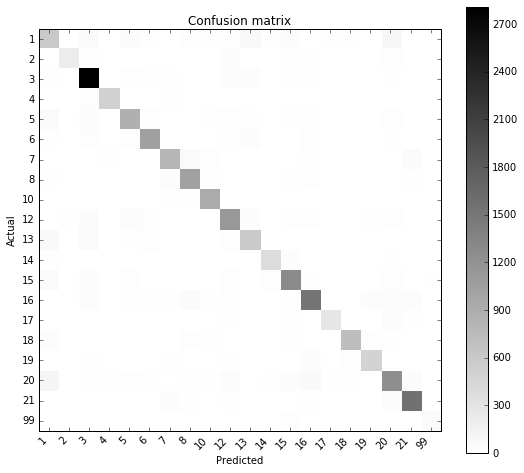

In [28]:
confusion_matrix.plot()

## Try SGDClassifier

In [29]:
if False:
    from sklearn.linear_model import SGDClassifier

    elastic_clf = SGDClassifier(loss='log', alpha=.00002, n_iter=200, penalty="elasticnet")
    t0 = time.time()
    elastic_clf.fit(X_train, y_train)
    t1 = time.time()
    prediction_elastic = elastic_clf.predict(X_test)
    t2 = time.time()
    time_elastic_train = t1-t0
    time_elastic_predict = t2-t1

    print("Results for Elastic Net")
    print("Training time: %fs; Prediction time: %fs" % (time_elastic_train, time_elastic_predict))
    print(classification_report(y_test, prediction_elastic))

In [30]:
if False:
    most_informative_feature_for_class(vect, elastic_clf, 99)

In [31]:
if False:
    print_top10(vect,  elastic_clf,  elastic_clf.classes_)

## Model (topic_1 == 1)

In [32]:
selected_topics = topics_df[topics_df.topic_1 == 1].code.unique()

In [33]:
selected_topics 

array([ 101,  105,  107,  201,  202,  206,  207,  301,  302,  323,  324,
        331,  332,  333,  335,  403,  404,  501,  502,  503,  504,  505,
        508,  529,  601,  603,  607,  609,  701,  703,  704,  705,  709,
        710,  801,  802,  803,  806,  807,  900, 1002, 1003, 1005, 1006,
       1007, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1301, 1302,
       1303, 1304, 1401, 1501, 1502, 1504, 1507, 1521, 1522, 1523, 1525,
       1602, 1603, 1605, 1609, 1610, 1612, 1615, 1701, 1706, 1707, 1709,
       1802, 1807, 1901, 1925, 1926, 1927, 2002, 2003, 2006, 2011, 2012,
       2013, 2101, 2102])

In [34]:
X = df[df.Minor.isin(selected_topics)].clean_text
y = df[df.Minor.isin(selected_topics)].Minor

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [35]:
X_train = vect.transform(X_train)
transformer = TfidfTransformer()
X_train = transformer.fit_transform(X_train)

In [36]:
X_test = vect.transform(X_test)
transformer = TfidfTransformer()
X_test = transformer.fit_transform(X_test)

In [37]:
# Perform classification with SVM, kernel=linear
classifier_liblinear = svm.LinearSVC()
t0 = time.time()
classifier_liblinear.fit(X_train, y_train)
t1 = time.time()
prediction_liblinear = classifier_liblinear.predict(X_test)
t2 = time.time()
time_liblinear_train = t1-t0
time_liblinear_predict = t2-t1

print("Results for LinearSVC()")
print("Training time: %fs; Prediction time: %fs" % (time_liblinear_train, time_liblinear_predict))
print(classification_report(y_test, prediction_liblinear))

Results for LinearSVC()
Training time: 216.443804s; Prediction time: 1.070281s
             precision    recall  f1-score   support

        101       0.50      0.14      0.22         7
        105       0.71      0.59      0.64       312
        107       0.68      0.76      0.72       615
        201       0.82      0.75      0.78        12
        202       0.53      0.45      0.49        51
        206       0.85      0.44      0.58        25
        207       0.87      0.71      0.78        28
        301       0.67      0.76      0.71       864
        302       0.58      0.57      0.57       440
        323       0.74      0.42      0.54        73
        324       0.53      0.37      0.44        65
        331       0.73      0.65      0.69       156
        332       0.73      0.69      0.71       207
        333       0.67      0.70      0.69        67
        335       0.73      0.77      0.75       187
        403       0.85      0.95      0.90       102
        404       0

In [38]:
most_informative_feature_for_class(vect, classifier_liblinear, 501)

501 lung benefit 0.963215094968
501 safeti health act 1.04849961898
501 modif thereof 1.10240466265
501 cover ill 1.11876027282
501 expos person 1.12607223819
501 asbesto claim 1.13543960793
501 drugfre workplac 1.18206501488
501 possibl modif 1.1904366756
501 energi employe 1.23245573086
501 safeti health 1.2977096667


In [39]:
print_top10(vect, classifier_liblinear, classifier_liblinear.classes_)

101: methodolog develop section | bureau econom | costofliv adjust | bureau econom analysi | cost live | function offic | statist servic | feder statist servic | feder statist | state shall effect
105: medicar choic organ | choic organ | possess corpor | sequestr order | spend reduct | act amend insert | deficit reduct | direct spend | public debt | medicar choic
107: busi activ | amend relat section | capit gain | foreign corpor | feder tax | gift tax | revenu servic | busi entiti | intern revenu servic | sale tax
201: racial discrimin | morril act | harass intimid | elimin racial profil | elimin racial | nation languag | cultur compet | institut slaveri | custom servic personnel | racial profil
202: perman partnership | gender equiti | econom selfsuffici | women scientist | discriminatori practic | administr judg | sexual harass | girl women | perman partner | sexual orient
206: servic voter | individu convict | electron vote | local elect | requir payment | standard board | parti ca

In [40]:
top_features = get_top_features(vect, classifier_liblinear, classifier_liblinear.classes_)
top_features_df = pd.DataFrame(top_features)
columns = []
for c in top_features_df.columns:
    cname = topics_df[topics_df.code == c].topic.values[0]
    columns.append(cname)
top_features_df.columns = columns
#top_features_df.to_csv('../data/topic_1_bills_top20_new.csv', index=False)
top_features_df

,"Inflation, Prices, and Interest Rates",National Budget and Debt,"Taxation, Tax policy, and Tax Reform",Ethnic Minority and Racial Group Discrimination,Gender and Sexual Orientation Discrimination,"Voting Rights, Participation, and Related Issues",Freedom of Speech & Religion,Comprehensive health care reform,"Insurance reform, availability, and cost",Provider and insurer payment and regulation,...,"International Organizations other than Finance: United Nations (UN), UNESCO, International Red Cross","Terrorism, Hijacking",Government Efficiency and Bureaucratic Oversight,Postal Service Issues (Including Mail Fraud),"Currency, Commemorative Coins, Medals, U.S. Mint","Federal Government Branch Relations and Administrative Issues, Congressional Operations","Regulation of Political Campaigns, Political Advertising, PAC regulation, Government Ethics",Census,"National Parks, Memorials, Historic Sites, and Recreation",Native American Affairs
0,state shall effect,medicar choic,sale tax,racial profil,sexual orient,vote right,partialbirth abort,region allianc,hapi plan,physician servic,...,unit nation,militari commiss,regulatori action,postal servic,commemor coin,member hous repres,feder elect,decenni censu,nation park,indian tribe
1,feder statist,public debt,intern revenu servic,custom servic personnel,perman partner,vote system,religi freedom,nation health,health coverag,amend titl xviii,...,foreclosur prevent,al qaeda,public printer,postag stamp,coin issu,member employe,polit parti,redistrict plan,nation histor,nativ hawaiian
2,feder statist servic,direct spend,busi entiti,institut slaveri,girl women,board advisor,perform abort,state health,health insur,restraint seclus,...,world health,terrorist organ,inspector gener,postal regulatori,gold medal,legisl branch,gener elect,american resid,heritag area,indian reserv
3,statist servic,deficit reduct,revenu servic,cultur compet,sexual harass,parti candid,free speech,health secur,medihealth plan,mortgag fraud,...,special olymp,insur loss,legisl propos,postal regulatori commiss,educ outreach,librarian congress,report individu,statist purpos,nation monument,nativ american
4,function offic,act amend insert,gift tax,nation languag,administr judg,standard board,unborn child,health board,independ home,regist nurs,...,strike constitut,review commiss,major system,post offic,feder reserv note,disapprov bill,lobbi activ,censu popul,scienc park,indian affair
5,cost live,spend reduct,feder tax,elimin racial,discriminatori practic,requir payment,flag unit,rural health,medic technolog,nurs aid,...,state olymp,militari commiss chapter,elig invest,skill contest,reserv note,special advoc,presidenti elect,resid abroad,nation memori,indian land
6,bureau econom analysi,sequestr order,foreign corpor,elimin racial profil,women scientist,local elect,flag unit state,health plan,plan purchas cooper,medicar reimburs,...,peacekeep oper,protect america,action purpos,offici mail,travel promot,presidenti order,lobbi disclosur,statist data,concess contract,game oper
7,costofliv adjust,possess corpor,capit gain,harass intimid,econom selfsuffici,electron vote,religi belief,advanc direct,tricar program,eye examin,...,unit state olymp,classifi inform,nation manufactur,rate postag,state mint,librari congress,paper ballot,statist data center,nation heritag,urban indian
8,bureau econom,choic organ,amend relat section,morril act,gender equiti,individu convict,sexual explicit,class program,manag care entiti,convers factor,...,intern crimin court,commiss chapter,feder review,frank mail,unit state mint,congression employe,elect campaign,independ redistrict,nation museum,tribe shall
9,methodolog develop section,medicar choic organ,busi activ,racial discrimin,perman partnership,servic voter,free exercis,commun health,valuebas payment,fee schedul,...,intern crimin,materi support,risk assess,postmast gener,numismat item,independ counsel,polit committe,apportion repres congress,smithsonian institut,indian game


In [41]:
from sklearn.externals import joblib

#joblib.dump(vect, "../models/vec_count_bills_23gram.joblib")
#joblib.dump(classifier_liblinear, "../models/topic_1_bills_clf_liblinear_new.joblib")

In [42]:
y_test_df = pd.DataFrame(y_test)
y_test_df['true_value'] = y_test_df['Minor'].apply(lambda c: topics_map[c])
y_test_df.reset_index(drop=True, inplace=True)

prob = classifier_liblinear.decision_function(X_test)
prob_df = pd.DataFrame(prob)
columns = []
for c in classifier_liblinear.classes_:
    cname = topics_map[c]
    columns.append(cname)
prob_df.columns = columns

result_df = pd.concat([y_test_df[['true_value']], prob_df], axis=1)
#result_df.to_csv('../data/test_prediction_topic_1.csv', index=False)
result_df

,true_value,"Inflation, Prices, and Interest Rates",National Budget and Debt,"Taxation, Tax policy, and Tax Reform",Ethnic Minority and Racial Group Discrimination,Gender and Sexual Orientation Discrimination,"Voting Rights, Participation, and Related Issues",Freedom of Speech & Religion,Comprehensive health care reform,"Insurance reform, availability, and cost",...,"International Organizations other than Finance: United Nations (UN), UNESCO, International Red Cross","Terrorism, Hijacking",Government Efficiency and Bureaucratic Oversight,Postal Service Issues (Including Mail Fraud),"Currency, Commemorative Coins, Medals, U.S. Mint","Federal Government Branch Relations and Administrative Issues, Congressional Operations","Regulation of Political Campaigns, Political Advertising, PAC regulation, Government Ethics",Census,"National Parks, Memorials, Historic Sites, and Recreation",Native American Affairs
0,"Insurance reform, availability, and cost",-1.045216,-1.175415,-1.235797,-1.054422,-1.130364,-1.057921,-1.097881,-0.256323,-1.196414,...,-1.055815,-1.051205,-1.016729,-1.062189,-1.045592,-1.066204,-1.057393,-1.053132,-1.064689,-1.066959
1,"Trade Negotiations, Disputes, and Agreements",-1.070222,-0.895984,-0.911537,-1.090540,-0.994205,-1.050164,-1.053624,-1.029187,-1.201538,...,-1.056355,-1.118867,-0.718405,-1.017996,-1.045183,-1.071974,-1.119462,-1.072040,-1.076535,-1.073593
2,"Insurance reform, availability, and cost",-1.059024,-0.974443,-1.113720,-1.056130,-1.050058,-1.084351,-1.035450,-0.808258,0.684569,...,-1.044084,-1.079061,-1.049615,-1.060881,-1.042173,-0.995539,-1.049428,-1.047295,-1.037591,-1.080070
3,Educational Excellence,-1.062167,-1.109871,-1.268490,-1.051349,-1.111028,-1.107331,-1.037447,-1.058054,-1.286882,...,-1.046158,-1.117445,-1.181605,-1.095199,-1.031190,-1.078579,-1.118247,-1.051099,-1.146179,-1.109955
4,Native American Affairs,-1.064288,-1.102751,-1.105235,-1.060884,-1.048912,-1.092276,-0.938861,-0.188295,-1.140056,...,-1.059136,-1.092563,-1.151278,-0.960944,-1.067277,-1.067062,-1.083048,-1.025681,-1.239555,0.006787
5,"Tariff and Import Restrictions, Import Regulation",-1.072525,-1.112296,-1.309244,-1.057014,-1.145642,-1.088179,-1.122715,-1.320090,-1.223688,...,-1.103480,-1.064165,-1.149661,-1.106500,-1.044176,-1.090461,-1.159299,-1.067420,-1.086744,-1.107602
6,Comprehensive health care reform,-1.058444,-1.133897,-1.073595,-1.060521,-1.079741,-1.078980,-1.038677,-0.089287,-1.151472,...,-1.043596,-0.995663,-1.237625,-1.039314,-1.050139,-1.088325,-1.069483,-1.062436,-1.103108,-0.367746
7,Arms Control and Nuclear Nonproliferation,-1.059037,-1.085974,-1.055075,-1.026966,-1.043176,-1.061354,-1.040398,-1.143695,-1.065637,...,-0.915109,-0.985968,-1.114186,-1.060596,-1.014580,-0.992582,-1.042328,-1.022533,-1.083175,-1.066890
8,"Regulation of Political Campaigns, Political A...",-1.093520,-1.447870,-1.588479,-1.059953,-1.099620,-1.160260,-1.050486,-1.262300,-1.101007,...,-1.020146,-1.143957,-1.277440,-1.084262,-1.088870,-1.334047,2.712462,-1.108086,-1.105175,-1.207011
9,Comprehensive health care reform,-1.065850,-0.965684,-1.188209,-1.074957,-1.103666,-1.073452,-1.062023,0.837181,-0.777146,...,-1.061145,-1.072002,-1.199543,-1.086923,-1.080471,-1.068147,-1.085618,-1.072226,-1.132363,-0.958654


In [43]:
y_true = y_test.reset_index(drop=True)
confusion_matrix = ConfusionMatrix(y_true, prediction_liblinear)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted  101  105  107  201  202  206  207  301  302  323   ...     1927  \
Actual                                                        ...            
101          1    0    0    0    0    0    0    0    0    0   ...        0   
105          0  183   21    0    0    0    0   21    5    1   ...        0   
107          0    7  465    0    0    0    1   10    4    0   ...        0   
201          0    0    2    9    0    0    0    0    0    0   ...        0   
202          0    0    0    0   23    0    0    0    0    0   ...        0   
206          0    0    0    0    0   11    0    0    0    0   ...        0   
207          0    0    0    0    0    0   20    1    0    0   ...        0   
301          0    1    1    0    1    0    0  658   92    3   ...        0   
302          0    2    5    0    0    0    1  101  250    3   ...        0   
323          0    0    1    0    0    0    0   20    8   31   ...        0   
324          0    1    0    0    0    0    0  

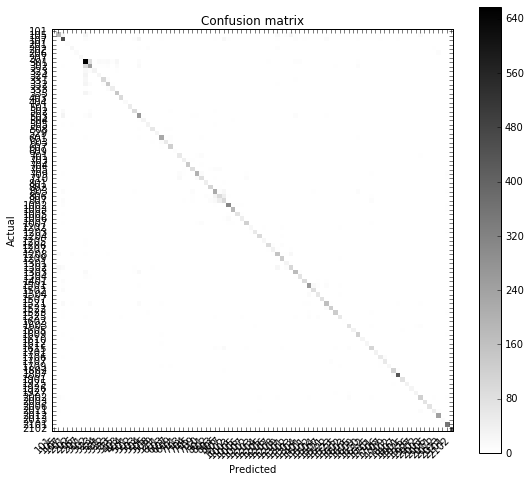

In [44]:
confusion_matrix.plot()

## Try LogisticRegression

In [45]:
if False:
    from sklearn.linear_model import LogisticRegression

    # Perform classification with LogisticRegression
    logreg_clf = LogisticRegression()
    t0 = time.time()
    logreg_clf.fit(X_train, y_train)
    t1 = time.time()
    prediction_logreg = logreg_clf.predict(X_test)
    t2 = time.time()
    time_logreg_train = t1-t0
    time_logreg_predict = t2-t1

    print("Results for LogisticRegression()")
    print("Training time: %fs; Prediction time: %fs" % (time_logreg_train, time_logreg_predict))
    print(classification_report(y_test, prediction_logreg))
    most_informative_feature_for_class(vect, logreg_clf, 501)
    print_top10(vect, logreg_clf, logreg_clf.classes_)